In [1]:
LOG_PATH = "Logs/19Mar2025"

import os, fnmatch
def find_uwb_scanner_logs(directory):
    matching_files = []
    for root, _, files in os.walk(directory):
        for filename in files:
            if fnmatch.fnmatch(filename, '*-uwb-scanner-log.json'):
                matching_files.append(os.path.join(root, filename))
    
    return matching_files

scans = []
import json
for file_path in find_uwb_scanner_logs(LOG_PATH):
    with open(file_path, 'r') as json_file:
            scan = json.load(json_file)
    scans.append(scan)

In [2]:
scan = scans[0]
scan[-7:-5]

[{'timestamp': 1742554050.1227999,
  'label': 'ARImageAnchor didUpdate',
  'content': {'transform': {'columns': [[-0.084071025,
      -0.017702859,
      0.9963024,
      0],
     [-0.995536, 0.044532336, -0.08321503, 0],
     [-0.042894557, -0.998851, -0.02136771, 0],
     [1.3523076, 0.83122647, 0.11539793, 1.0000001]]},
   'name': 'Mandrill',
   'identifier': 'A19C2489-597B-2BED-432C-244B551E75FD'}},
 {'label': 'ARImageAnchor didAdd',
  'content': {'name': 'Sailboat',
   'identifier': 'C35EAC54-3E90-1B97-807B-5E3B8F238DB7',
   'transform': {'columns': [[0.9960044, 0.001521847, 0.089289755, 0],
     [-0.0892838, -0.003624062, 0.9959995, 0],
     [0.0018393517, -0.99999225, -0.0034737112, 0],
     [0.6694388, 0.8063038, -0.501356, 1]]}},
  'timestamp': 1742554053.916902}]

In [3]:
delays = []
for scan in scans:
    connectionInitiationTimestamp = next(filter(lambda s: s['label'] == "Connecting To Beacon", scan))['timestamp']
    firstConsecutiveThresholdPassedTimestamp = next(filter(lambda s: s['label'] == "Stop Signal With firstConsecutiveThresholdPassedTimestamp", scan))['content']+978307200
    delays.append(firstConsecutiveThresholdPassedTimestamp-connectionInitiationTimestamp)
delays[:5]

[10.117316007614136,
 25.764965057373047,
 14.8174569606781,
 5.000729084014893,
 29.267225980758667]

(-0.1, 0.1)

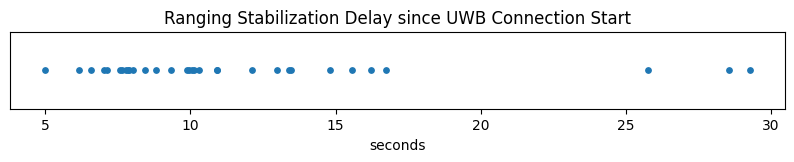

In [4]:
import matplotlib.pyplot as plt
import numpy as np
y_values = np.zeros_like(delays)

plt.figure(figsize=(10, 1))
plt.scatter(delays, y_values, marker='o', s = 15)
plt.title('Ranging Stabilization Delay since UWB Connection Start')
plt.xlabel('seconds')
plt.yticks([])  
plt.ylim(-0.1, 0.1)

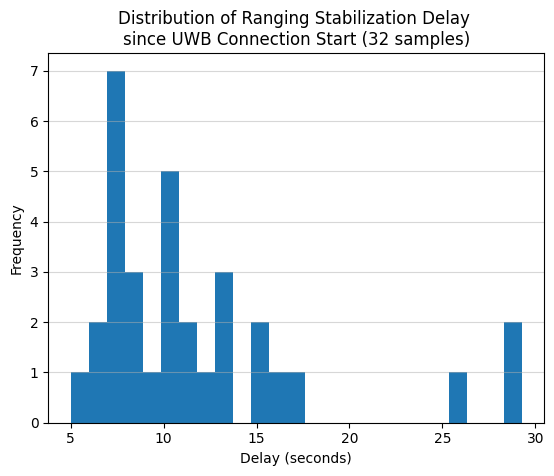

In [5]:
plt.hist(delays, bins=25)
plt.title(f'Distribution of Ranging Stabilization Delay \nsince UWB Connection Start ({len(delays)} samples)')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)

In [6]:
from helper import *

beacon_locations = []
for scan in scans:
    ImageRefs = dict()
    beacon_world_position = None
    for entry in scan:
        if entry["label"] == "Beacon is Stabled":
            beacon_world_position = Position(entry["content"]["position"])
        elif entry["label"].startswith("ARImageAnchor"):
            transform = np.array(entry["content"]["transform"]["columns"]).transpose()
            name = entry["content"]["name"]
            if name not in ImageRefs:
                ImageRefs[name] = []
            ImageRefs[name].append(ThreeDObject(matrix=transform))
    avgImageRefs = dict()
    for name, objects in ImageRefs.items():
        avgImageRefs[name] = ThreeDObject.avg(objects)
    avgImageRef = ThreeDObject.avg(avgImageRefs.values())
    relative_location, _, _ = (ThreeDObject(position=beacon_world_position).relativePoseRefBy(avgImageRef)).decompose()
    beacon_locations.append(relative_location)
beacon_locations[:5]

[Position: [-0.46060193 -0.16362659  0.52832187],
 Position: [-0.4420445  -0.13859942  0.58469161],
 Position: [-0.47442266 -0.21712834  0.52257249],
 Position: [-0.44426894 -0.09981999  0.57745332],
 Position: [-0.4318259  -0.11169393  0.57476415]]

In [7]:
positions = np.array([p.value for p in beacon_locations]) * 100
min = [positions[:,0].min(), positions[:,1].min(), positions[:,2].min()]
positions = positions - min
positions[:5]

array([[ 1.38207311,  5.35017453,  1.29797195],
       [ 3.23781614,  7.85289139,  6.9349464 ],
       [ 0.        ,  0.        ,  0.72303415],
       [ 3.01537228, 11.73083425,  6.21111745],
       [ 4.25967611, 10.54344093,  5.94220035]])

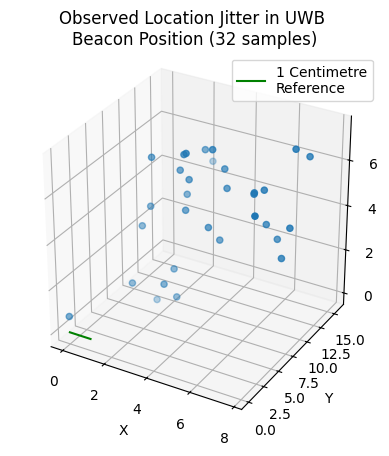

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
plt.title(f'Observed Location Jitter in UWB \nBeacon Position ({len(positions)} samples)')

scale_length = 1.0
x_start, y_start, z_start = 0, 0, 0 
ax.plot([x_start, x_start + scale_length], [y_start, y_start], [z_start, z_start], color='g', label="1 Centimetre\nReference")
ax.legend()

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_box_aspect([1, 1, 1]) 

plt.show()